# Insights - Total population by year

## Introduction

This process is dependent on upstream processes. See the "Prerequisites" section below.

The workflow defined herein is identified as workflow ID #90 in the the [Data Team Master Document List](https://morpc1.sharepoint.com/:x:/s/GISteam/EfC4j3HhohZCrSZzxJdyt5cBFEqVD7zHick8ZW0INqgCYA?e=0WhrAI). References to document list identifiers are denoted by a number in brackets, e.g. [90].

## Process outline

  1. Load input dataset
  2. Extract required population facts
  3. Transform population facts to comply with output schema
  4. Export output dataset
  5. Create resource file

## Prerequisites and usage notes

  - Outputs of one or more upstream workflows must be available at the indicated paths. Make sure that those outputs are up to date prior to running this script. 
  - This script includes several intentional RuntimeError instances that may be triggered to alert the user to conditions that may require their attention. If the script triggers one of these errors, review the error, verify that the condition is acceptable or resolve any issues, then proceed.

## Setup

### Import required packages

In [1]:
import os
import shutil
import sys
import pandas as pd
import frictionless
import matplotlib
from matplotlib import pyplot as plt
sys.path.append(os.path.normpath("../morpc-common"))
import morpc
import morpcCensus

### User-specified parameters

In [2]:
MORPC_ESTIMATE_YEAR_RANGE = [2021, 2024]

MORPC_FORECAST_VINTAGE = 2023
MORPC_FORECAST_YEAR_RANGE = [2025, 2050]
MORPC_FORECAST_YEAR_INTERVAL = 5

DECENNIAL_YEAR_RANGE = [1980, 2020]
INTERCENSAL_YEAR_RANGE = [2000, 2019]

PEP_YEAR_RANGE = [INTERCENSAL_YEAR_RANGE[1]+1, MORPC_ESTIMATE_YEAR_RANGE[0]-1]

# When STALE_DATA_INTERRUPT == True, the script will produce a RuntimeError in certain situations where the input 
# data may be stale and updates might be required prior to running the script.  Otherwise, a warning will be generated 
# but script execution will continue.  Regardless of whether an error or warning occurs, be sure to verify the readiness 
# of all input data.
STALE_DATA_INTERRUPT = True

# You can change where the input data is sourced and archived by changing the following directory and file names.  
# This typically is not necessary and may break other scripts that depend on outputs from this one. Source data 
# will be copied to this location.  Input data will be deleted following successful completion of the script 
# unless PRESERVE_INPUT_DATA == True.
INPUT_DIR = "./input_data"

# You can change where the output data is stored by changing the following directory and file names.  This 
# typically is not necessary and may break other scripts that depend on outputs from this one.
OUTPUT_DIR = "./output_data"

### Static parameters

Create a map to convert human-readable source descriptions to shortened codes to save space.

In [3]:
GEO_TYPE_LIST = ["COUNTY","PLACE","COUNTY-TOWNSHIP-REMAINDER"]

SOURCE_MAP = {
    "Census Intercensal Estimates":"CENINT",
    "Census Population Estimates Program":"CENPEP",
    "Mid-Ohio Regional Planning Commission":"MORPC"
}

SOURCE_MAP_REVERSED = {value: key for key, value in SOURCE_MAP.items()}

GEO_TYPE_LABELS = {
    "COUNTY":" County",
    "COUNTY-TOWNSHIP-REMAINDER":" Township (unincorporated)",
    "PLACE":""
}

### Define inputs

The following datasets are required by this notebook. They will be retrieved from the specified location and temporarily stored in INPUT_DIR. They will be deleted following successful completion of the script unless PRESERVE_INPUT_DATA == True.

#### Create input data directory

Create input data directory if it doesn't exist.

In [4]:
inputDir = os.path.normpath(INPUT_DIR)
if not os.path.exists(inputDir):
    os.makedirs(inputDir)

#### MORPC counties reference data [81]

Reference data for counties in the MORPC region will be loaded automatically as a morpc.countyLookup() object (see below).

#### MORPC combined population facts [286]

In [5]:
COMBINED_POP_FACTS_RESOURCE_PATH = "../morpc-pop-collect/output_data/morpc-pop-collect.resource.yaml"
print("Resource file: {}".format(COMBINED_POP_FACTS_RESOURCE_PATH))

Resource file: ../morpc-pop-collect/output_data/morpc-pop-collect.resource.yaml


#### MORPC geography lookup table [375]

In [6]:
GEOS_LOOKUP_RESOURCE_PATH = "../morpc-geos-collect/output_data/morpc-geos-lookup.resource.yaml"
print("Resource file: {}".format(GEOS_LOOKUP_RESOURCE_PATH))

Resource file: ../morpc-geos-collect/output_data/morpc-geos-lookup.resource.yaml


### Define outputs

#### Create output data directory

Create output data directory if it doesn't exist.

In [7]:
outputDir = os.path.normpath(OUTPUT_DIR)
if not os.path.exists(outputDir):
    os.makedirs(outputDir)   

#### Insights total population by year [287]

In [8]:
INSIGHTS_POP_TABLE_FILENAME = "morpc-insights-pop-temporal.csv"
INSIGHTS_POP_TABLE_PATH = os.path.join(outputDir, INSIGHTS_POP_TABLE_FILENAME)
INSIGHTS_POP_TABLE_SCHEMA_PATH = INSIGHTS_POP_TABLE_PATH.replace(".csv",".schema.yaml")
INSIGHTS_POP_TABLE_RESOURCE_PATH = INSIGHTS_POP_TABLE_PATH.replace(".csv",".resource.yaml")
print("Data: {}".format(INSIGHTS_POP_TABLE_PATH))
print("Schema: {}".format(INSIGHTS_POP_TABLE_SCHEMA_PATH))
print("Resource file: {}".format(INSIGHTS_POP_TABLE_RESOURCE_PATH))

Data: output_data\morpc-insights-pop-temporal.csv
Schema: output_data\morpc-insights-pop-temporal.schema.yaml
Resource file: output_data\morpc-insights-pop-temporal.resource.yaml


## Prepare input data

### Load county reference data

In [9]:
countyLookup = morpc.countyLookup(scope="15-County Region")

Loading data for MORPC 15-County region only


In [10]:
",".join(countyLookup.list_ids())

'39041,39045,39047,39049,39073,39083,39089,39091,39097,39101,39117,39127,39129,39141,39159'

### Combined population facts

In [11]:
(combinedPopRaw, combinedPopResource, combinedPopSchema) = morpc.frictionless_load_data(COMBINED_POP_FACTS_RESOURCE_PATH, archiveDir=inputDir, validate=True, verbose=True)

morpc.load_frictionless_data | INFO | Loading Frictionless Resource file at location ..\morpc-pop-collect\output_data\morpc-pop-collect.resource.yaml
morpc.load_frictionless_data | INFO | Copying data, resource file, and schema to directory input_data
morpc.load_frictionless_data | INFO | --> Data file: input_data\morpc-pop-collect.csv
morpc.load_frictionless_data | INFO | --> Resource file: input_data\morpc-pop-collect.resource.yaml
morpc.load_frictionless_data | INFO | --> Schema file: input_data\morpc-pop-collect.schema.yaml
morpc.load_frictionless_data | INFO | Validating resource including data and schema.
morpc.frictionless_validate_resource | INFO | Validating resource on disk (including data and schema). This may take some time.
morpc.frictionless_validate_resource | INFO | Resource is valid
morpc.load_frictionless_data | INFO | Loading data.
frictionless_cast_field_types | INFO | Casting field POP as type integer.
frictionless_cast_field_types | WARNING | Failed conversion of 

In [12]:
combinedPop = combinedPopRaw.copy()

In [13]:
combinedPop["GEO_TYPE"] = combinedPop["SUMLEVEL"].map(morpc.HIERARCHY_STRING_LOOKUP)

In [14]:
combinedPop = combinedPop.drop(columns=["SUMLEVEL","LAST_UPDATED"]) 

In [15]:
combinedPop = combinedPop.loc[combinedPop["GEO_TYPE"].isin(GEO_TYPE_LIST)]

In [16]:
combinedPop.head()

,POP,GEOIDFQ,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE
0,111714,0500000US39041,2000,Y-JUN,2009,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY
1,111759,0500000US39041,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY
2,119098,0500000US39041,2001,Y-JUN,2009,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY
3,118646,0500000US39041,2001,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY
4,127011,0500000US39041,2002,Y-JUN,2009,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY


### Geography lookup table

In [17]:
(geoLookupRaw, geoLookupResource, geoLookupSchema) = morpc.frictionless_load_data(GEOS_LOOKUP_RESOURCE_PATH, archiveDir=inputDir, validate=True, verbose=True)

morpc.load_frictionless_data | INFO | Loading Frictionless Resource file at location ..\morpc-geos-collect\output_data\morpc-geos-lookup.resource.yaml
morpc.load_frictionless_data | INFO | Copying data, resource file, and schema to directory input_data
morpc.load_frictionless_data | INFO | --> Data file: input_data\morpc-geos-lookup.csv
morpc.load_frictionless_data | INFO | --> Resource file: input_data\morpc-geos-lookup.resource.yaml
morpc.load_frictionless_data | INFO | --> Schema file: input_data\morpc-geos-lookup.schema.yaml
morpc.load_frictionless_data | INFO | Validating resource including data and schema.
morpc.frictionless_validate_resource | INFO | Validating resource on disk (including data and schema). This may take some time.
morpc.frictionless_validate_resource | INFO | Resource is valid
morpc.load_frictionless_data | INFO | Loading data.
frictionless_cast_field_types | INFO | Casting field GEOIDFQ as type string.
frictionless_cast_field_types | INFO | Casting field GEOID 

In [18]:
geoLookup = geoLookupRaw.copy() \
    .set_index("GEOIDFQ")

In [19]:
geoLookup.head()

,GEOID,SUMLEVEL,GEOTYPE,NAME,SOURCE,STATEFP,COUNTYFP,COUSUBFP,PLACEFP,TRACTCE,CLASSFP,MUNITYPE,PLACECOMBO
GEOIDFQ,,,,,,,,,,,,,
0500000US39041,39041,050,COUNTY,Delaware,CENSUS,39,041,<NA>,<NA>,<NA>,H1,<NA>,<NA>
0500000US39045,39045,050,COUNTY,Fairfield,CENSUS,39,045,<NA>,<NA>,<NA>,H1,<NA>,<NA>
0500000US39047,39047,050,COUNTY,Fayette,CENSUS,39,047,<NA>,<NA>,<NA>,H1,<NA>,<NA>
0500000US39049,39049,050,COUNTY,Franklin,CENSUS,39,049,<NA>,<NA>,<NA>,H1,<NA>,<NA>
0500000US39073,39073,050,COUNTY,Hocking,CENSUS,39,073,<NA>,<NA>,<NA>,H1,<NA>,<NA>


## Transform data

#### Load output schema

In [150]:
insightsPopSchema = morpc.frictionless_load_schema(INSIGHTS_POP_TABLE_SCHEMA_PATH)
insightsPopSchema

{'fields': [{'name': 'GEOIDFQ',
             'type': 'string',
             'description': 'Unique identifier for the geography as issued by '
                            'MORPC.  These are identical to fully-qualified '
                            'Census-issued GEOIDs for Census geographies.'},
            {'name': 'Name',
             'type': 'string',
             'description': 'Name of the geography.'},
            {'name': 'Geography type',
             'type': 'string',
             'description': 'Code which designates the summary level '
                            '(geography type) for which the GEOID applies.  '
                            'The combination of GEO_TYPE and GEOID uniquely '
                            'identify the geography for the record.'},
            {'name': 'Date',
             'type': 'date',
             'description': 'ISO8601-compliant date string that identifies the '
                            'reference date for which the estimate applies'},
  

### Create list to collect extracted data

In [21]:
extractedData = []

### Extract decennial census counts (NOT IMPLEMENTED)

### Extract intercensal estimates

Create list of years from user-specified range.

In [22]:
intercensalRange = list(range(INTERCENSAL_YEAR_RANGE[0], INTERCENSAL_YEAR_RANGE[1]+1))
print("Including intercensal estimates for years: {}".format(", ".join([str(x) for x in intercensalRange])))

Including intercensal estimates for years: 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019


Extract intercensal data from combined table.

In [23]:
intercensal = combinedPop.loc[combinedPop["SOURCE"] == "CENINT"].copy()

Reference period and vintage period were stored as strings, but for intercensal estimates we can treat them as integers. Convert them now.

In [24]:
intercensal = intercensal.astype({
    "REFERENCE_PERIOD":"int",
    "VINTAGE_PERIOD":"int"
})

Verify that data is available for the specified years.

In [25]:
if(not set(intercensalRange).issubset(set(intercensal["REFERENCE_PERIOD"]))):
    print("ERROR | Set of intercensal years for which data is available does not match set derived from specified range.")
    print("Specified range: {}".format(INTERCENSAL_YEAR_RANGE))
    print("Specified set: {}".format(set(intercensalRange)))
    print("Available set: {}".format(set(intercensal["REFERENCE_PERIOD"])))
    raise RuntimeError
else:
    print("INFO | Intercensal data is available for all years in specified range.")

INFO | Intercensal data is available for all years in specified range.


Extract only the estimates for the specified years.

In [26]:
intercensal = morpc.extract_vintage(intercensal, refPeriods=intercensalRange)

Verify that all reference periods are present and that there is only a single vintage for each reference period.

In [27]:
for year in intercensal["REFERENCE_PERIOD"].unique():
    temp = intercensal.loc[intercensal["REFERENCE_PERIOD"] == year]
    print("{0}: {1}".format(year, ",".join(temp["VINTAGE_PERIOD"].unique().astype("str"))))

2000: 2012
2001: 2012
2002: 2012
2003: 2012
2004: 2012
2005: 2012
2006: 2012
2007: 2012
2008: 2012
2009: 2012
2010: 2024
2011: 2024
2012: 2024
2013: 2024
2014: 2024
2015: 2024
2016: 2024
2017: 2024
2018: 2024
2019: 2024


Construct DATE field from reference period and reference period frequency.

In [28]:
if(intercensal["REFERENCE_PERIOD_FREQ"].unique().shape[0] == 1):
    freq = intercensal["REFERENCE_PERIOD_FREQ"].iat[0]
    print("INFO | Detected reference period frequency {}".format(freq))
else:
    print("ERROR | Multiple reference period frequencies are not supported.")
    raise RuntimeError

try:
    # Hopefully this works properly with newer versions of pandas, but it has not been tested
    periodIndex = pd.PeriodIndex(intercensal["REFERENCE_PERIOD"]+1, freq=freq)
except:
    # This works with older versions of pandas. Note the +1 offset. For whatever reason, pandas converts 2000 Y-JUN (for example)
    # to a timestamp of 1999-07-01 so we add one year to the reference period so the timestamp becomes 2000-07-01.
    print("WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.")
    periodIndex = pd.PeriodIndex(intercensal["REFERENCE_PERIOD"]+1, freq=freq.replace("Y-","A-"))
intercensal["DATE"] = periodIndex.to_timestamp()

INFO | Detected reference period frequency Y-JUN
WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.


Show the data.

In [29]:
intercensal.head()

,POP,GEOIDFQ,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE,DATE
1,111759,0500000US39041,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,2000-07-01
62,123485,0500000US39045,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,2000-07-01
123,28495,0500000US39047,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,2000-07-01
184,1072018,0500000US39049,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,2000-07-01
245,28262,0500000US39073,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,2000-07-01


In [30]:
extractedData.append(intercensal)

### Extract PEP estimates

Create list of years from user-specified range.

In [31]:
pepRange = list(range(PEP_YEAR_RANGE[0], PEP_YEAR_RANGE[1]+1))
print("Including PEP estimates for years: {}".format(", ".join([str(x) for x in pepRange])))

Including PEP estimates for years: 2020


Extract PEP estimates from combined table.

In [32]:
pep = combinedPop.loc[combinedPop["SOURCE"] == "CENPEP"].copy()

Reference period and vintage period were stored as strings, but for Census PEP estimates we can treat them as integers. Convert them now.

In [33]:
pep = pep.astype({
    "REFERENCE_PERIOD":"int",
    "VINTAGE_PERIOD":"int"
})

Verify that data is available for the specified years.

In [34]:
if(not set(pepRange).issubset(set(pep["REFERENCE_PERIOD"]))):
    print("ERROR | Set of Census PEP years for which data is available does not match set derived from specified range.")
    print("Specified range: {}".format(PEP_YEAR_RANGE))
    print("Specified set: {}".format(set(pepRange)))
    print("Available set: {}".format(set(pep["REFERENCE_PERIOD"])))
    raise RuntimeError
else:
    print("INFO | PEP data is available for all years in specified range.")

INFO | PEP data is available for all years in specified range.


Extract only the estimates for the specified years.

In [35]:
pep = morpc.extract_vintage(pep, refPeriods=pepRange)

Verify that all reference periods are present and that there is only a single vintage for each reference period.

In [36]:
for year in pep["REFERENCE_PERIOD"].unique():
    temp = pep.loc[pep["REFERENCE_PERIOD"] == year]
    print("{0}: {1}".format(year, ",".join(temp["VINTAGE_PERIOD"].unique().astype("str"))))

2020: 2023


Construct DATE field from reference period and reference period frequency.

In [37]:
if(pep["REFERENCE_PERIOD_FREQ"].unique().shape[0] == 1):
    freq = pep["REFERENCE_PERIOD_FREQ"].iat[0]
    print("INFO | Detected reference period frequency {}".format(freq))
else:
    print("ERROR | Multiple reference period frequencies are not supported.")
    raise RuntimeError

try:
    # Hopefully this works properly with newer versions of pandas, but it has not been tested
    periodIndex = pd.PeriodIndex(pep["REFERENCE_PERIOD"]+1, freq=freq)
except:
    # This works with older versions of pandas. Note the +1 offset. For whatever reason, pandas converts 2000 Y-JUN (for example)
    # to a timestamp of 1999-07-01 so we add one year to the reference period so the timestamp becomes 2000-07-01.
    print("WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.")
    periodIndex = pd.PeriodIndex(pep["REFERENCE_PERIOD"]+1, freq=freq.replace("Y-","A-"))
pep["DATE"] = periodIndex.to_timestamp()

INFO | Detected reference period frequency Y-JUN
WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.


Show the data.

In [38]:
pep.head()

,POP,GEOIDFQ,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE,DATE
43,215166,0500000US39041,2020,Y-JUN,2023,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY,2020-07-01
104,159448,0500000US39045,2020,Y-JUN,2023,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY,2020-07-01
165,28975,0500000US39047,2020,Y-JUN,2023,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY,2020-07-01
226,1324441,0500000US39049,2020,Y-JUN,2023,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY,2020-07-01
287,28040,0500000US39073,2020,Y-JUN,2023,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENPEP,COUNTY,2020-07-01


In [39]:
extractedData.append(pep)

### Extract MORPC county estimates

Because county estimates and sub-county estimates are generated (and regenerated) at different times, it is necessary to process each separately. Start with county estimates.

Create list of years from user-specified range.

In [40]:
morpcEstimatesRange = list(range(MORPC_ESTIMATE_YEAR_RANGE[0], MORPC_ESTIMATE_YEAR_RANGE[1]+1))
print("Including MORPC estimates for years: {}".format(", ".join([str(x) for x in morpcEstimatesRange])))

Including MORPC estimates for years: 2021, 2022, 2023, 2024


Extract MORPC county estimates from combined table.

In [41]:
morpcCountyEstimates = combinedPop.loc[
    (combinedPop["SOURCE"] == "MORPC") & 
    (combinedPop["VALUE_TYPE"] == "ESTIMATE") &
    (combinedPop["GEO_TYPE"] == "COUNTY")
].copy()

Reference period and vintage period were stored as strings, but for MORPC estimates we can treat them as integers. Convert them now.

In [42]:
morpcCountyEstimates = morpcCountyEstimates.astype({
    "REFERENCE_PERIOD":"int",
    "VINTAGE_PERIOD":"int"
})

Verify that data is available for the specified years.

In [43]:
if(not set(morpcEstimatesRange).issubset(set(morpcCountyEstimates["REFERENCE_PERIOD"]))):
    print("ERROR | Set of MORPC estimate years for which data is available does not match set derived from specified range.")
    print("Specified range: {}".format(MORPC_ESTIMATE_YEAR_RANGE))
    print("Specified set: {}".format(set(morpcEstimatesRange)))
    print("Available set: {}".format(set(morpcCountyEstimates["REFERENCE_PERIOD"])))
    raise RuntimeError
else:
    print("INFO | MORPC county estimates data is available for all years in specified range.")

INFO | MORPC county estimates data is available for all years in specified range.


Extract only the estimates for the specified years.

In [44]:
morpcCountyEstimates = morpc.extract_vintage(morpcCountyEstimates, refPeriods=morpcEstimatesRange)

Verify that all reference periods are present and that there is only a single vintage for each reference period.

In [45]:
for year in morpcCountyEstimates["REFERENCE_PERIOD"].unique():
    temp = morpcCountyEstimates.loc[morpcCountyEstimates["REFERENCE_PERIOD"] == year]
    print("{0}: {1}".format(year, ",".join(temp["VINTAGE_PERIOD"].unique().astype("str"))))

2021: 2024
2022: 2024
2023: 2024
2024: 2024


Construct DATE field from reference period and reference period frequency.

In [46]:
if(morpcCountyEstimates["REFERENCE_PERIOD_FREQ"].unique().shape[0] == 1):
    freq = morpcCountyEstimates["REFERENCE_PERIOD_FREQ"].iat[0]
    print("INFO | Detected reference period frequency {}".format(freq))
else:
    print("ERROR | Multiple reference period frequencies are not supported.")
    raise RuntimeError

try:
    # Hopefully this works properly with newer versions of pandas, but it has not been tested
    periodIndex = pd.PeriodIndex(morpcCountyEstimates["REFERENCE_PERIOD"], freq=freq)
except:
    # This works with older versions of pandas.
    print("WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.")
    periodIndex = pd.PeriodIndex(morpcCountyEstimates["REFERENCE_PERIOD"], freq=freq.replace("Y-","A-"))
morpcCountyEstimates["DATE"] = periodIndex.to_timestamp()

INFO | Detected reference period frequency Y-DEC
WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.


Show the data.

In [47]:
morpcCountyEstimates.head()

,POP,GEOIDFQ,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE,DATE
47,216437,0500000US39041,2021,Y-DEC,2024,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY,2021-01-01
108,159773,0500000US39045,2021,Y-DEC,2024,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY,2021-01-01
169,28922,0500000US39047,2021,Y-DEC,2024,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY,2021-01-01
230,1326880,0500000US39049,2021,Y-DEC,2024,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY,2021-01-01
291,27939,0500000US39073,2021,Y-DEC,2024,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY,2021-01-01


In [48]:
extractedData.append(morpcCountyEstimates)

### Extract MORPC sub-county estimates

Because county estimates and sub-county estimates are generated (and regenerated) at different times, it is necessary to process each separately.

Create list of years from user-specified range.

In [49]:
morpcEstimatesRange = list(range(MORPC_ESTIMATE_YEAR_RANGE[0], MORPC_ESTIMATE_YEAR_RANGE[1]+1))
print("Including MORPC estimates for years: {}".format(", ".join([str(x) for x in morpcEstimatesRange])))

Including MORPC estimates for years: 2021, 2022, 2023, 2024


Extract MORPC county estimates from combined table.

In [50]:
morpcSubCountyEstimates = combinedPop.loc[
    (combinedPop["SOURCE"] == "MORPC") & 
    (combinedPop["VALUE_TYPE"] == "ESTIMATE") &
    (combinedPop["GEO_TYPE"] != "COUNTY")
].copy()

Reference period and vintage period were stored as strings, but for MORPC estimates we can treat them as integers. Convert them now.

In [51]:
morpcSubCountyEstimates = morpcSubCountyEstimates.astype({
    "REFERENCE_PERIOD":"int",
    "VINTAGE_PERIOD":"int"
})

Verify that data is available for the specified years.

In [52]:
if(not set(morpcEstimatesRange).issubset(set(morpcSubCountyEstimates["REFERENCE_PERIOD"]))):
    print("ERROR | Set of MORPC estimate years for which data is available does not match set derived from specified range.")
    print("Specified range: {}".format(MORPC_ESTIMATE_YEAR_RANGE))
    print("Specified set: {}".format(set(morpcEstimatesRange)))
    print("Available set: {}".format(set(morpcSubCountyEstimates["REFERENCE_PERIOD"])))
    raise RuntimeError
else:
    print("INFO | MORPC sub-county estimates data is available for all years in specified range.")

INFO | MORPC sub-county estimates data is available for all years in specified range.


Extract only the estimates for the specified years.

In [53]:
morpcSubCountyEstimates = morpc.extract_vintage(morpcSubCountyEstimates, refPeriods=morpcEstimatesRange)

Verify that all reference periods are present and that there is only a single vintage for each reference period.

In [54]:
for year in morpcSubCountyEstimates["REFERENCE_PERIOD"].unique():
    temp = morpcSubCountyEstimates.loc[morpcSubCountyEstimates["REFERENCE_PERIOD"] == year]
    print("{0}: {1}".format(year, ",".join(temp["VINTAGE_PERIOD"].unique().astype("str"))))

2021: 2021
2022: 2022
2023: 2023
2024: 2024


Construct DATE field from reference period and reference period frequency.

In [55]:
if(morpcSubCountyEstimates["REFERENCE_PERIOD_FREQ"].unique().shape[0] == 1):
    freq = morpcSubCountyEstimates["REFERENCE_PERIOD_FREQ"].iat[0]
    print("INFO | Detected reference period frequency {}".format(freq))
else:
    print("ERROR | Multiple reference period frequencies are not supported.")
    raise RuntimeError

try:
    # Hopefully this works properly with newer versions of pandas, but it has not been tested
    periodIndex = pd.PeriodIndex(morpcSubCountyEstimates["REFERENCE_PERIOD"], freq=freq)
except:
    # This works with older versions of pandas.
    print("WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.")
    periodIndex = pd.PeriodIndex(morpcSubCountyEstimates["REFERENCE_PERIOD"], freq=freq.replace("Y-","A-"))
morpcSubCountyEstimates["DATE"] = periodIndex.to_timestamp()

INFO | Detected reference period frequency Y-DEC
WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.


Show the data.

In [56]:
morpcSubCountyEstimates.head()

,POP,GEOIDFQ,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE,DATE
13677,4641,0700000US390410577499999,2021,Y-DEC,2021,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY-TOWNSHIP-REMAINDER,2021-01-01
13687,7930,0700000US390410578899999,2021,Y-DEC,2021,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY-TOWNSHIP-REMAINDER,2021-01-01
13697,1406,0700000US390410942899999,2021,Y-DEC,2021,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY-TOWNSHIP-REMAINDER,2021-01-01
13707,11117,0700000US390411814099999,2021,Y-DEC,2021,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY-TOWNSHIP-REMAINDER,2021-01-01
13717,2133,0700000US390412144899999,2021,Y-DEC,2021,Y-DEC,ESTIMATE,NaN,<NA>,<NA>,MORPC,COUNTY-TOWNSHIP-REMAINDER,2021-01-01


In [57]:
extractedData.append(morpcSubCountyEstimates)

### Extract MORPC forecasts

Create list of years from user-specified range.

In [58]:
morpcForecastsRange = list(range(MORPC_FORECAST_YEAR_RANGE[0], MORPC_FORECAST_YEAR_RANGE[1]+1, MORPC_FORECAST_YEAR_INTERVAL))
print("Including MORPC forecasts for years: {}".format(", ".join([str(x) for x in morpcForecastsRange])))

Including MORPC forecasts for years: 2025, 2030, 2035, 2040, 2045, 2050


Extract MORPC forecasts from combined table.

In [59]:
morpcForecasts = combinedPop.loc[(combinedPop["SOURCE"] == "MORPC") & (combinedPop["VALUE_TYPE"] == "FORECAST")].copy()

Reference period and vintage period were stored as strings, but for MORPC forecasts we can treat them as integers. Convert them now.

In [60]:
morpcForecasts = morpcForecasts.astype({
    "REFERENCE_PERIOD":"int",
    "VINTAGE_PERIOD":"int"
})

Verify that data is available for the specified years.

In [61]:
if(not set(morpcForecastsRange).issubset(set(morpcForecasts["REFERENCE_PERIOD"]))):
    print("ERROR | Set of MORPC forecast years for which data is available does not match set derived from specified range.")
    print("Specified range: {}".format(MORPC_FORECAST_YEAR_RANGE))
    print("Specified set: {}".format(set(morpcForecastsRange)))
    print("Available set: {}".format(set(morpcForecasts["REFERENCE_PERIOD"])))
    raise RuntimeError
else:
    print("INFO | MORPC forecasts data is available for all years in specified range.")

INFO | MORPC forecasts data is available for all years in specified range.


Extract only the estimates for the specified years.  The forecasts for different geographies come from different sources, so it is necessary to extract the latest vintage separately for each geography type.

In [62]:
extractIndex = []
for group in morpcForecasts["GEO_TYPE"].unique():
    temp = morpcForecasts.loc[morpcForecasts["GEO_TYPE"] == group].copy()
    temp = morpc.extract_vintage(temp, refPeriods=morpcForecastsRange)
    extractIndex += list(temp.index)
morpcForecasts = morpcForecasts.loc[extractIndex].copy()

For each geography type, verify that all reference periods are present and that there is only a single vintage for each reference period.

In [63]:
for group in morpcForecasts["GEO_TYPE"].unique():
    print(group)
    for year in morpcForecasts["REFERENCE_PERIOD"].unique():
        temp = morpcForecasts.loc[(morpcForecasts["REFERENCE_PERIOD"] == year) & (morpcForecasts["GEO_TYPE"] == group)]
        print("{0}: {1}".format(year, ",".join(temp["VINTAGE_PERIOD"].unique().astype("str"))))

COUNTY
2025: 2023
2030: 2023
2035: 2023
2040: 2023
2045: 2023
2050: 2023
COUNTY-TOWNSHIP-REMAINDER
2025: 2024
2030: 2024
2035: 2024
2040: 2024
2045: 2024
2050: 2024
PLACE
2025: 2024
2030: 2024
2035: 2024
2040: 2024
2045: 2024
2050: 2024


Construct DATE field from reference period and reference period frequency.

In [64]:
if(morpcForecasts["REFERENCE_PERIOD_FREQ"].unique().shape[0] == 1):
    freq = morpcForecasts["REFERENCE_PERIOD_FREQ"].iat[0]
    print("INFO | Detected reference period frequency {}".format(freq))
else:
    print("ERROR | Multiple reference period frequencies are not supported.")
    raise RuntimeError

try:
    # Hopefully this works properly with newer versions of pandas, but it has not been tested
    periodIndex = pd.PeriodIndex(morpcForecasts["REFERENCE_PERIOD"]+1, freq=freq)
except:
    # This works with older versions of pandas. Note the +1 offset. For whatever reason, pandas converts 2000 Y-JUN (for example)
    # to a timestamp of 1999-07-01 so we add one year to the reference period so the timestamp becomes 2000-07-01.
    print("WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.")
    periodIndex = pd.PeriodIndex(morpcForecasts["REFERENCE_PERIOD"]+1, freq=freq.replace("Y-","A-"))
morpcForecasts["DATE"] = periodIndex.to_timestamp()

INFO | Detected reference period frequency Y-JUN
WARNING | Error occurred when attempting to create period index using 'Y-' format. Trying legacy 'A-' format.


Show the data.

In [65]:
morpcForecasts.head()

,POP,GEOIDFQ,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE,DATE
55,247016,0500000US39041,2025,Y-JUN,2023,<NA>,FORECAST,0.8,248441,238464,MORPC,COUNTY,2025-07-01
116,169183,0500000US39045,2025,Y-JUN,2023,<NA>,FORECAST,0.8,171704,163990,MORPC,COUNTY,2025-07-01
177,29419,0500000US39047,2025,Y-JUN,2023,<NA>,FORECAST,0.8,29855,28912,MORPC,COUNTY,2025-07-01
238,1390127,0500000US39049,2025,Y-JUN,2023,<NA>,FORECAST,0.8,1409654,1333445,MORPC,COUNTY,2025-07-01
299,27965,0500000US39073,2025,Y-JUN,2023,<NA>,FORECAST,0.8,28660,27122,MORPC,COUNTY,2025-07-01


In [66]:
extractedData.append(morpcForecasts)

### Combine extracted data

In [67]:
combinedData = pd.concat(extractedData, axis="index")

In [68]:
combinedData

,POP,GEOIDFQ,REFERENCE_PERIOD,REFERENCE_PERIOD_FREQ,VINTAGE_PERIOD,VINTAGE_PERIOD_FREQ,VALUE_TYPE,CONF_LEVEL,CONF_LIMIT_UPPER,CONF_LIMIT_LOWER,SOURCE,GEO_TYPE,DATE
1,111759,0500000US39041,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,2000-07-01
62,123485,0500000US39045,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,2000-07-01
123,28495,0500000US39047,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,2000-07-01
184,1072018,0500000US39049,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,2000-07-01
245,28262,0500000US39073,2000,Y-JUN,2012,<NA>,ESTIMATE,NaN,<NA>,<NA>,CENINT,COUNTY,2000-07-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30534,5338,1600000US3983580,2050,Y-JUN,2024,<NA>,FORECAST,NaN,<NA>,<NA>,MORPC,PLACE,2050-07-01
30684,210,1600000US3984182,2050,Y-JUN,2024,<NA>,FORECAST,NaN,<NA>,<NA>,MORPC,PLACE,2050-07-01
30738,23060,1600000US3984742,2050,Y-JUN,2024,<NA>,FORECAST,NaN,<NA>,<NA>,MORPC,PLACE,2050-07-01
30792,1032,1600000US3985414,2050,Y-JUN,2024,<NA>,FORECAST,NaN,<NA>,<NA>,MORPC,PLACE,2050-07-01


### Reformat combined data for output

Create a working dataframe to prepare for export.

In [151]:
insightsPop = combinedData.copy()

Merge the geography name and the class FIPS code from the geography lookup table, aligning on fully-qualified GEOID.

In [152]:
insightsPop = insightsPop.merge(geoLookup.reset_index()[["GEOIDFQ","NAME","SUMLEVEL"]], on="GEOIDFQ")

In [153]:
townshipsTemp = insightsPop.loc[insightsPop["SUMLEVEL"] == morpc.SUMLEVEL_LOOKUP["COUNTY-TOWNSHIP-REMAINDER"]].copy()
townshipsTemp["NAME"] = townshipsTemp["NAME"] + " Township"
insightsPop.update(townshipsTemp, overwrite=True)

In [154]:
insightsPop = insightsPop.filter(items=["POP","GEOIDFQ","GEO_TYPE","NAME","DATE","VALUE_TYPE","CONF_LIMIT_UPPER","CONF_LIMIT_LOWER"], axis="columns")

In [155]:
insightsPop = insightsPop.pivot(index=["GEOIDFQ","GEO_TYPE","NAME","DATE","CONF_LIMIT_UPPER","CONF_LIMIT_LOWER"], columns="VALUE_TYPE", values="POP").reset_index()

In [156]:
insightsPop = insightsPop.rename(columns={
    "NAME":"Name",
    "GEO_TYPE":"Geography type",
    "DATE":"Date",
    "ESTIMATE":"Historical",
    "FORECAST":"Forecast",
    "CONF_LIMIT_UPPER":"Confidence limit (upper)",
    "CONF_LIMIT_LOWER":"Confidence limit (lower)"
})

In [157]:
insightsPop = insightsPop.filter(items=insightsPopSchema.field_names, axis="columns")

In [158]:
insightsPop = morpc.cast_field_types(insightsPop, insightsPopSchema)

frictionless_cast_field_types | INFO | Casting field GEOIDFQ as type string.
frictionless_cast_field_types | INFO | Casting field Name as type string.
frictionless_cast_field_types | INFO | Casting field Geography type as type string.
frictionless_cast_field_types | INFO | Casting field Date as type date.
frictionless_cast_field_types | INFO | Casting field Historical as type integer.
frictionless_cast_field_types | WARNING | Failed conversion of fieldname Historical to type 'int'.  Trying type 'Int64' instead.
frictionless_cast_field_types | INFO | Casting field Forecast as type integer.
frictionless_cast_field_types | WARNING | Failed conversion of fieldname Forecast to type 'int'.  Trying type 'Int64' instead.
frictionless_cast_field_types | INFO | Casting field Confidence limit (upper) as type integer.
frictionless_cast_field_types | WARNING | Failed conversion of fieldname Confidence limit (upper) to type 'int'.  Trying type 'Int64' instead.
frictionless_cast_field_types | INFO | 

In [159]:
insightsPop.head()

,GEOIDFQ,Name,Geography type,Date,Historical,Forecast,Confidence limit (upper),Confidence limit (lower)
0,0500000US39041,Delaware,COUNTY,2000-07-01,111759,<NA>,<NA>,<NA>
1,0500000US39041,Delaware,COUNTY,2001-07-01,118646,<NA>,<NA>,<NA>
2,0500000US39041,Delaware,COUNTY,2002-07-01,126172,<NA>,<NA>,<NA>
3,0500000US39041,Delaware,COUNTY,2003-07-01,133842,<NA>,<NA>,<NA>
4,0500000US39041,Delaware,COUNTY,2004-07-01,141348,<NA>,<NA>,<NA>


In [161]:
insightsPop = insightsPop.sort_values(["Geography type","Name","Date"])

## Export data

In [162]:
insightsPop.to_csv(INSIGHTS_POP_TABLE_PATH, index=False)

## Create resource file for exported data

In [163]:
insightsPopResource = morpc.frictionless_create_resource(INSIGHTS_POP_TABLE_FILENAME, 
    resourcePath=INSIGHTS_POP_TABLE_RESOURCE_PATH,
    title="MORPC Insights | Historic and Forecasted Population by Year", 
    name="morpc_insights_pop_temporal", 
    description="This dataset provides the best available historical and forecasted population estimates for the Central Ohio region and the counties and communities therein.  Estimates are compiled from a variety of sources including the following: {}.  Note that different sources provide estimates as of different days throughout the year, so be sure to note the entire date in the REFERENCE_PERIOD field.  The VINTAGE_PERIOD field refers to the time that the estimate was produced or released.  Earlier and (perhaps) later vintages may be available from the original sources.".format(", ".join(["{1} ({0})".format(value, key) for key, value in SOURCE_MAP.items()])),
    writeResource=True,
    validate=True
)

morpc.frictionless_create_resource | INFO | Format not specified. Using format derived from data file extension: csv
morpc.frictionless_create_resource | INFO | Schema path not specified. Using path derived from data file path: morpc-insights-pop-temporal.schema.yaml
morpc.frictionless_create_resource | INFO | Writing Frictionless Resource file to output_data\morpc-insights-pop-temporal.resource.yaml
morpc.frictionless_create_resource | INFO | Validating resource on disk.
morpc.frictionless_validate_resource | INFO | Validating resource on disk (including data and schema). This may take some time.
morpc.frictionless_validate_resource | INFO | Resource is valid


## Generate thumbnail images

In [201]:
insightsPop.loc[insightsPop["Name"] == "Reynoldsburg"]

,GEOIDFQ,Name,Geography type,Date,Historical,Forecast,Confidence limit (upper),Confidence limit (lower)
5548,1600000US3966390,Reynoldsburg,PLACE,2000-07-01,32168,<NA>,<NA>,<NA>
5549,1600000US3966390,Reynoldsburg,PLACE,2001-07-01,32576,<NA>,<NA>,<NA>
5550,1600000US3966390,Reynoldsburg,PLACE,2002-07-01,32864,<NA>,<NA>,<NA>
5551,1600000US3966390,Reynoldsburg,PLACE,2003-07-01,33190,<NA>,<NA>,<NA>
5552,1600000US3966390,Reynoldsburg,PLACE,2004-07-01,33493,<NA>,<NA>,<NA>
5553,1600000US3966390,Reynoldsburg,PLACE,2005-07-01,33831,<NA>,<NA>,<NA>
5554,1600000US3966390,Reynoldsburg,PLACE,2006-07-01,34252,<NA>,<NA>,<NA>
5555,1600000US3966390,Reynoldsburg,PLACE,2007-07-01,34690,<NA>,<NA>,<NA>
5556,1600000US3966390,Reynoldsburg,PLACE,2008-07-01,35156,<NA>,<NA>,<NA>
5557,1600000US3966390,Reynoldsburg,PLACE,2009-07-01,35610,<NA>,<NA>,<NA>


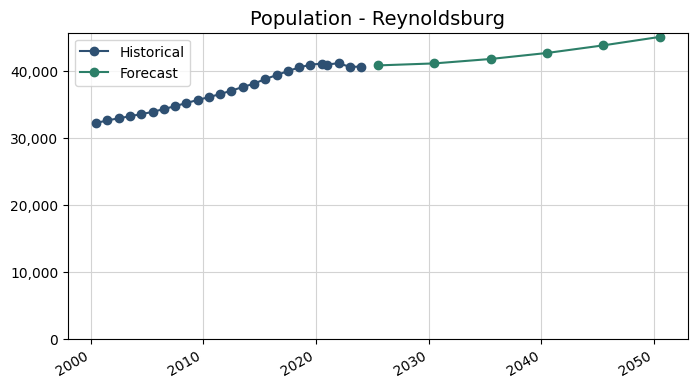

In [202]:
#for geoid in ["0500000US39041","0500000US39049"]:# insightsPop["GEOIDFQ"].unique():
#temp = insightsPop.loc[insightsPop["GEOIDFQ"] == "0500000US39041"] #geoid]
temp = insightsPop.loc[insightsPop["GEOIDFQ"] == "1600000US3966390"] #geoid]
geoName = temp.iloc[0]["Name"]
geoType = temp.iloc[0]["Geography type"]
geoLabel = "Population - {}{}".format(geoName, GEO_TYPE_LABELS[geoType]) 
PLOTWIDTH = 8
fig,ax = plt.subplots(figsize=(PLOTWIDTH,PLOTWIDTH/16*9))
temp.plot(ax=ax, x="Date", y="Historical", marker="o", color=morpc.CONST_MORPC_COLORS["darkblue"])
temp.plot(ax=ax, x="Date", y="Forecast", marker="o", color=morpc.CONST_MORPC_COLORS["darkgreen"])
if(not temp["Confidence limit (upper)"].isnull().all()):
    temp.plot(ax=ax, x="Date", y="Confidence limit (upper)", label="Confidence limit", color="grey")
    temp.plot(ax=ax, x="Date", y="Confidence limit (lower)", legend=False, color="grey")
ax.set_title(geoLabel, fontsize=14)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.grid(visible=True, color="lightgrey")
ax.set_ylim(ymin=0)
ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))